In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten, InputLayer, Conv1D
from tensorflow.keras.optimizers import Adam

from rl.agents import DQNAgent, CEMAgent, DDPGAgent, SARSAAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

import numpy as np

from gym import Env
from gym.spaces import Box, Discrete

import pandas as pd
import matplotlib.pyplot as plt

from os.path import exists

from scipy.stats import norm

rng = np.random.default_rng()

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [2]:
class TakeItEasyEnv(Env):
    def __init__(self):
        self.action_space = Discrete(20, start=1)
        self.observation_space = Box(low=-100, high=96100, shape=(1,1,20,3), dtype=np.int32)
        self.state = np.zeros(shape=(20, 3), dtype=np.int32)
        self.episode_length = 19
        self.round_no = 0
        self.pieces = np.array([
            [2,1,3], [2,1,4], [2,1,8], [6,1,3], [6,1,4], [6,1,8], [7,1,3], [7,1,4], [7,1,8], 
            [2,5,3], [2,5,4], [2,5,8], [6,5,3], [6,5,4], [6,5,8], [7,5,3], [7,5,4], [7,5,8],
            [2,9,3], [2,9,4], [2,9,8], [6,9,3], [6,9,4], [6,9,8], [7,9,3], [7,9,4], [7,9,8]])
        self.cases = np.array([
            [[1,4,8,0,0], [2,5,9,13,0], [3,6,10,14,17], [7,11,15,18,0], [12,16,19,0,0]],
            [[1,2,3,0,0], [4,5,6,7,0], [8,9,10,11,12], [13,14,15,16,0], [17,18,19,0,0]], 
            [[3,7,12,0,0], [2,6,11,16,0], [1,5,10,15,19], [4,9,14,18,0], [8,13,17,0,0]]       
            ], np.int32)
        self.last_reward = 0
        self.selected_pieces = rng.choice(self.pieces, size=self.episode_length, replace=False)


        self.state[0] = self.selected_pieces[0]

    def count_points(self, state):
        points=0
        for i in range(3):
            for j in range(5):
                first_value = state[self.cases[i][j][0],i]
                for k in range(5):
                    if(self.cases[i][j][k] == 0):
                        points += first_value*k
                        break
                    if(self.state[self.cases[i][j][k], i] != first_value):
                        break
                    elif(k == 4):
                        points += first_value*(k+1)
                        break
        return points

    def reset(self):
        self.round_no = 0
        self.last_reward = 0
        self.state=np.zeros(shape=(20, 3), dtype=np.int32)
        self.selected_pieces = rng.choice(self.pieces, size=self.episode_length, replace=False)
        self.state[0] = self.selected_pieces[0]
        return self.state
    
    def step(self, action):
        self.round_no += 1
        reward = 0

        if(np.all(self.state[action] != 0) and self.round_no <= self.episode_length):
            reward = -100
            done = True
        else:
            if(self.round_no == self.episode_length):
                self.state[action] = self.state[0]
                reward = 2*self.count_points(self.state) - self.last_reward
                done = True
            else:
                self.state[action] = self.state[0]
                self.state[0] = self.selected_pieces[self.round_no]
                reward = self.count_points(self.state) - self.last_reward
                self.last_reward = self.count_points(self.state)
                done = False

        info = {}

        return self.state, reward, done, info


In [3]:
env=TakeItEasyEnv()

states = env.observation_space.shape
actions = env.action_space.n

In [4]:
def build_model(states, actions):
    model = Sequential()
    model.add(InputLayer(input_shape=(1,20,3)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Flatten())
    model.add(Dense(actions, activation='linear'))
    return model

model = build_model(states, actions)

In [6]:
def build_agent(model, actions):
    memory = SequentialMemory(limit=200000000, window_length=1)
    policy = BoltzmannQPolicy()
    dqn = DQNAgent(model=model, nb_actions=actions, memory=memory, nb_steps_warmup=100, target_model_update=1e-2, policy=policy)
    
    return dqn

dqn = build_agent(model, actions)

dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.load_weights('dqn_take-it-easy_weights-BACKUP.hdf5')

In [36]:
test_rounds = int(input("How many rounds do you want to test? "))

test_results = dqn.test(env, nb_episodes=test_rounds, visualize=False, verbose=0)

                 0
count  1000.000000
mean     94.495000
std      22.207773
min       4.000000
25%      75.000000
50%     102.000000
75%     107.250000
max     157.000000


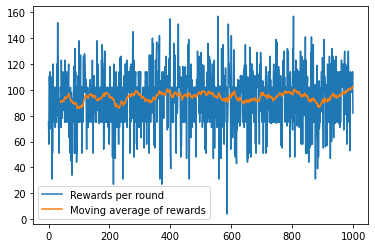

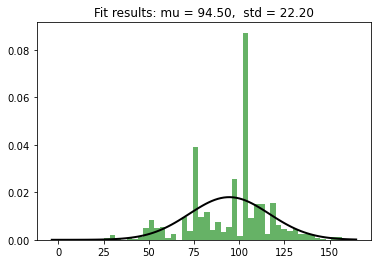

In [37]:
rewards = pd.DataFrame(test_results.history['episode_reward'])
rewards = rewards.apply(lambda x: x/2)

print(rewards.describe())

rewards_MA = rewards.rolling(window=test_rounds//25).mean()

plt.plot(rewards, label='Rewards per round')
plt.plot(rewards_MA, label='Moving average of rewards')
plt.legend()
plt.show()


mu, std = norm.fit(rewards)
plt.hist(rewards, bins=50, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.show()